In [56]:
# Imports
import math
import numpy as np
from collections import deque
from copy import deepcopy
import random
from tqdm.notebook import tqdm
import sys
from common import *
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import networkx as nx
from surprise.model_selection import cross_validate
from surprise import BaselineOnly, Dataset, Reader, AlgoBase
from networkx import node_classification
from RandomWalkMC import random_walk_mc
from JaccardRandomWalkMC import jacc_random_walk_mc
import networkx as nx
import Baselines
from utils import *
from importlib import reload

from Baselines import *
from TrustWalk import *
 
sys.setrecursionlimit(10**6)

In [211]:
# Combining item jaccard and item difference
def item_similarity_recommender(alpha=0.1):
    def recommender(graph, ratings, rated_by, item, test_points):
        rb = set(rated_by[item])
        recommendations = {n : ratings[n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in graph:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += alpha*(ITEM_JACCARDS[node - 1, o_v - 1]) + (1-alpha)*(ITEM_DIFFS_NEW[str(node)][str(o_v)])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def intra_item_majority(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph[node]:
            if o_v == node:
                continue
            for o_item, rating in ratings[o_v].items():
                similarity_vals[rating - 1] += TOP_100_ITEM_SIMS[item][o_item]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

# Weighted average version
def intra_item_WA(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph[node]:
            if o_v == node:
                continue
            for o_item, rating in ratings[o_v].items():
                similarity_vals[rating - 1] += TOP_100_ITEM_SIMS[item][o_item]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations


def item_jaccard_recommender(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (ITEM_JACCARDS[node - 1, o_v - 1])
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_rating_diff_recommender(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (1 - ITEM_DIFFS[node - 1, o_v - 1])
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_rating_diff_recommender_new(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += ITEM_DIFFS_NEW[str(node)][str(o_v)]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def item_rating_diff_recommender_new(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += ITEM_DIFFS_NEW[str(node)][str(o_v)]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def weighted_item_diffs(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += WEIGHTED_ITEM_DIFFS[str(node)][str(o_v)]
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

# Weighted average version
def item_rating_diff_recommender_WA(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in list(test_points):
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (1 - ITEM_DIFFS[node - 1, o_v - 1])
        
        sorted_vals = sorted(filter(lambda x: x[0] > 0.2, zip(similarity_vals, [1,2,3,4,5])), key=lambda x: x[0], reverse=True)
        
        recommendations[node] = round(np.average([x[1] for x in sorted_vals[:5]], weights=[x[0] for x in sorted_vals[:5]]))
        

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_majority_of_majorities(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (JACCARD_MATRIX[node - 1, o_v - 1])
        recommendations[node] = np.argmax(similarity_vals) + 1
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations

def jaccard_weighted_neighbours(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph[node]:
            if o_v == node:
                continue
            if o_v in recommendations:
                similarity_vals[recommendations[o_v] - 1] += (JACCARD_MATRIX[node - 1, o_v - 1])
        recommendations[node] = np.argmax(similarity_vals) + 1
        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])

    return recommendations

def mode_of_neighbours(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in graph[node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = stats.mode(ratings)[0][0]

    return recommendations

def mean_of_neighbours(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in graph[node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = np.mean(ratings)

    return recommendations

def median_of_neighbours(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}

    for node in list(test_points): # loop through nodes which need recommendation
        ratings = []
        for neighbour in graph[node]:
            if neighbour in recommendations:
                ratings.append(recommendations[neighbour])
        
        if len(ratings) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
        else:
            recommendations[node] = np.median(ratings)

    return recommendations

def jaccard_intra_item(graph, ratings, rated_by, item, test_points):
    rb = set(rated_by[item])
    recommendations = {n : ratings[n][item] for n in rb}
    
    for node in test_points: # loop through nodes which need recommendation
        similarity_vals = [0 for _ in range(5)]
        for o_v in graph:
            if o_v == node:
                continue
            for o_item, rating in ratings[o_v].items():
                similarity_vals[rating - 1] += JACCARD_MATRIX[node -1, o_v -1]*(TOP_100_ITEM_SIMS[item][o_item])
        
        recommendations[node] = np.argmax(similarity_vals) + 1

        if np.max(similarity_vals) == 0:
            recommendations[node] = random.choice([1,2,3,4,5])
            
    return recommendations

def jaccard_item_rating(alpha=0.1):
    def recommender(graph, ratings, rated_by, item, test_points):
        rb = set(rated_by[item])
        recommendations = {n : ratings[n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in graph:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += alpha*(JACCARD_MATRIX[node - 1, o_v - 1]) + (1-alpha)*(ITEM_DIFFS_NEW[str(node)][str(o_v)])
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender


def jaccard_item_rating_test(alpha=0.1):
    jaccard_test = np.power(JACCARD_MATRIX, 0.05)
    def recommender(graph, ratings, rated_by, item, test_points):
        rb = set(rated_by[item])
        recommendations = {n : ratings[n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in graph:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    scalar = 10 if jaccard_test[node - 1, o_v  -1] > 0.5 else 1
                    similarity_vals[recommendations[o_v] - 1] += scalar * ITEM_DIFFS_NEW[str(node)][str(o_v)]
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

def jaccard_item_rating_test_1(alpha=0.1):
    def recommender(graph, ratings, rated_by, item, test_points):
        rb = set(rated_by[item])
        recommendations = {n : ratings[n][item] for n in rb}
        
        for node in test_points: # loop through nodes which need recommendation
            similarity_vals = [0 for _ in range(5)]
            for o_v in graph:
                if o_v == node:
                    continue
                if o_v in recommendations:
                    similarity_vals[recommendations[o_v] - 1] += JACCARD_MATRIX[node - 1, o_v - 1]*ITEM_DIFFS_NEW[str(node)][str(o_v)]
            
            recommendations[node] = np.argmax(similarity_vals) + 1

            if np.max(similarity_vals) == 0:
                recommendations[node] = random.choice([1,2,3,4,5])
                
        return recommendations
    return recommender

In [71]:
# Goals
# 1. Confine graph to those who have rated top 5
# 2. Make predictions with only information about graph structure and other's ratings
#       - This means using intra-item similarities from other users

# Need to make our comparisons more similar
# So restrict the nodes to only those who have voted the first node, don't test across items [DONE]

# Think about other ways to approach the argmax, one example is the weighted average, we can cut off the outlier small ratings [DONE]

# Take a trustwalker approach/Random walk with the intra-item data [DONE]

# NEXT STEPS
# Connecting item graph with intra-item diff, i.e. weighted sum [DONE]
# Connecting item graph with jaccard graph, i.e. random walk methods
# Next steps -> Combine item-based network with intra-item, similar to how we did with social network/intra item
#               -> Finally we will combine our understanding of these 

In [186]:
results = {}

In [212]:
# Make dict to hold results
tests = {
    # 'weighted rating difference': weighted_item_diffs,
    # 'intra-item MoM': intra_item_majority,
    # 'jaccard intra-item MoM': jaccard_intra_item,
    'item-rating difference MoM': item_rating_diff_recommender_new,
    # 'jaccard item-rating difference MoM (Addition, a=0.5)': jaccard_item_rating(alpha=0.5),
    # 'jaccard item-rating difference MoM (Multiplication)': jaccard_item_rating_test_1(alpha=0.5),
    #'jaccard item-rating difference MoM (Max, power scaling)': jaccard_item_rating_test(alpha=0.5),
    'jaccard item-rating difference MoM (Multiplication, power scaling)': jaccard_item_rating_test(alpha=0.5),
    'jaccard item-rating difference MoM (Additive, power scaling)': jaccard_item_rating_test(alpha=0.5),
    'jaccard item-rating difference MoM (Scalar Test, power scaling)': jaccard_item_rating_test(alpha=0.5),
    # 'item-jaccard MoM': item_jaccard_recommender,
    # 'trust based jaccard': jaccard_recommender,
    # 'trust walk': trust_walk_recommender,
    'jaccard MoM': jaccard_majority_of_majorities,
    # 'similarity recommender': item_similarity_recommender,
    # 'jaccard weighted neighbours': jaccard_weighted_neighbours,
    # 'mode of neighbours': mode_of_neighbours,
    # 'monte-carlo random walk': random_walk_mc,
    # 'jaccard MC random walk': jacc_random_walk_mc,
    # 'median of neighbours': median_of_neighbours,
    # 'mean of neighbours': mean_of_neighbours,
    'random': Baselines.random_recommender,
    'universal random': Baselines.universal_recommender,
}

# Top 5 items
ITEMS = ORDERED_ITEMS[:5]

reduced_graph, reduced_ratings, reduced_rated_by = remove_non_voters(TRUST_GRAPH, RATINGS, RATED_BY, ITEMS)

for k, recommender in tqdm(tests.items()):
    if k in results:
        continue
    sample_sizes, accs, mses, mes = [], [], [], [] 
    for i in ITEMS: 
        for _ in range(50): # run 5 times for each item
            acc, mse, me = evaluate(recommender, reduced_graph, reduced_ratings, reduced_rated_by, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me)

    results[k] = {
        'sample_sizes': sample_sizes,
        'acc': accs,
        'mse': mses,
        'me': mes
    }

  0%|          | 0/7 [00:00<?, ?it/s]

In [213]:
import colorsys
N = len(results)
HSV_tuples = [(x*1.0/N, 0.85, 0.7) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
random.shuffle(RGB_tuples)

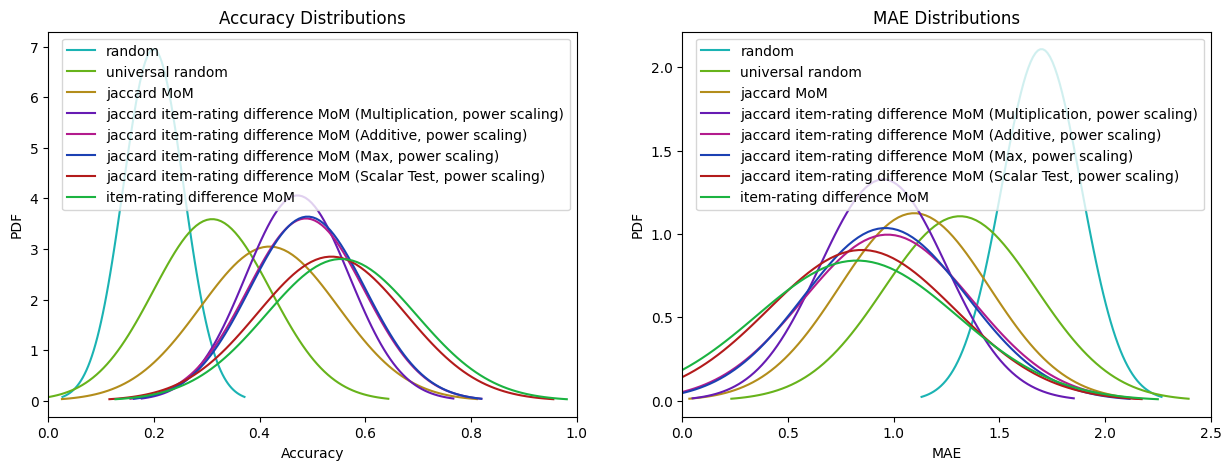

In [214]:
fig = plt.figure(figsize=(15, 5))

# plt.subplot(5,1,1)
# plt.title("Mean squared error")
# for i, (name, res) in enumerate(results.items()):
#     plt.plot(res['sample_sizes'], np.median(res['mse'], axis=1), label=name, color=RGB_tuples[i])
#     for x, y in zip(res['sample_sizes'], res['mse']):
#         plt.plot(x, min(y), marker='o', markersize=2, color=RGB_tuples[i])
#         plt.plot(x, max(y), marker='o',  markersize=2, color=RGB_tuples[i])
# plt.legend()
# plt.ylabel("MSE")
# plt.xlabel("Ratio of sample to recommend for")

# plt.subplot(5,1,2)
# plt.title("Mean Absolute Error")
# for i, (name, res) in enumerate(results.items()):
#     plt.plot(res['sample_sizes'], np.median(res['me'], axis=1), label=name, color=RGB_tuples[i])
#     for x, y in zip(res['sample_sizes'], res['me']):
#         plt.plot(x, min(y), marker='o', markersize=2, color=RGB_tuples[i])
#         plt.plot(x, max(y), marker='o',  markersize=2, color=RGB_tuples[i])
# plt.legend()
# plt.ylabel("MAE")
# plt.xlabel("Ratio of sample to recommend for")

# plt.subplot(5,1,3)
# plt.title("Accuracy")
# for i, (name, res) in enumerate(results.items()):
#     plt.plot(res['sample_sizes'], np.median(res['acc'], axis=1), label=name, color=RGB_tuples[i])
#     for x, y in zip(res['sample_sizes'], res['acc']):
#         plt.plot(x, min(y), marker='o', markersize=2, color=RGB_tuples[i])
#         plt.plot(x, max(y), marker='o',  markersize=2, color=RGB_tuples[i])
# plt.legend()
# plt.ylabel("ACC")
# plt.xlabel("Ratio of sample to recommend for")

plt.subplot(1,2,1)
plt.title("Accuracy Distributions")
plt.xlim(0, 1)
result_items = sorted(list(results.items()), key=lambda x: np.mean(x[1]['acc']))

for i, (name, res) in enumerate(result_items):
    mu = np.mean(res['acc'])
    sigma = np.std(res['acc'])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=name, color=RGB_tuples[i])
plt.legend()
plt.ylabel("PDF")
plt.xlabel("Accuracy")

plt.subplot(1,2,2)
plt.xlim(0, 2.5)
plt.title("MAE Distributions")
for i, (name, res) in enumerate(result_items):
    mu = np.mean(res['me'])
    sigma = np.std(res['me'])
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=name, color=RGB_tuples[i])
plt.legend()
plt.ylabel("PDF")
plt.xlabel("MAE")

plt.show()

Text(0, 0.5, 'Accuracy')

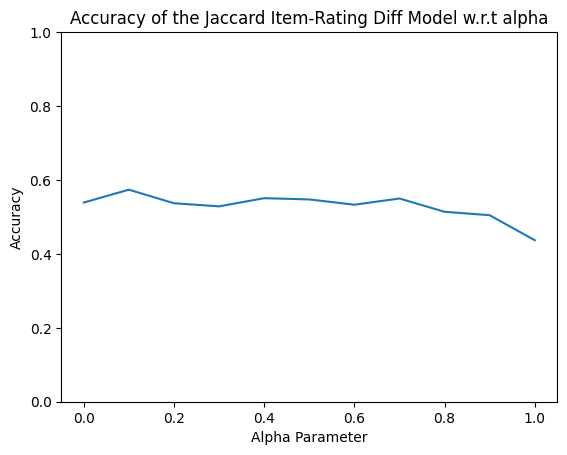

In [97]:
similarity_results = {}
for alpha in np.arange(0, 1.1, 0.1):
    sample_sizes, accs, mses, mes = [], [], [], [] 
    for i in ITEMS: 
        for _ in range(5): # run 5 times for each item
            acc, mse, me = evaluate(jaccard_item_rating(alpha), reduced_graph, reduced_ratings, reduced_rated_by, i, 0.15) # remove 15% of ratings
            accs.append(acc), mses.append(mse), mes.append(me)
    similarity_results[alpha] = {'acc': accs, 'mse': mses, 'me': mes}
    
mean_res = {alpha:np.mean(data['acc']) for alpha, data in similarity_results.items()}

plt.title('Accuracy of the Jaccard Item-Rating Diff Model w.r.t alpha')
plt.plot(mean_res.keys(), mean_res.values(), label='Mean')
plt.ylim(0, 1)

plt.xlabel('Alpha Parameter')
plt.ylabel('Accuracy')

In [176]:
x_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)
y_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)

points = JACCARD_MATRIX[x_ind, y_ind]

transformed_matrix_power = np.power(points, 0.05)
min_val = np.min(transformed_matrix_power)
max_val = np.max(transformed_matrix_power)
transformed_matrix_power = (transformed_matrix_power - min_val) / (max_val - min_val)

# Logarithmic transformation
epsilon = 0.001
transformed_matrix_log = np.log(points + epsilon)
min_val = np.min(transformed_matrix_log)
max_val = np.max(transformed_matrix_log)
transformed_matrix_log = (transformed_matrix_log - min_val) / (max_val - min_val)

/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_22529/2200985190.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 49288 + 1) instead
  x_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)
/var/folders/cf/34nwhx1j74v31xqy3qcrtw800000gn/T/ipykernel_22529/2200985190.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 49288 + 1) instead
  y_ind = np.random.random_integers(0, len(JACCARD_MATRIX) - 1, 100000)


In [157]:
vals = [v for val in ITEM_DIFFS_NEW.values() for v in val.values()]

(array([3.049569e+06, 6.138380e+05, 2.065600e+05, 1.108700e+05,
        3.220000e+02, 6.803100e+04, 0.000000e+00, 3.205600e+04,
        0.000000e+00, 2.343000e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

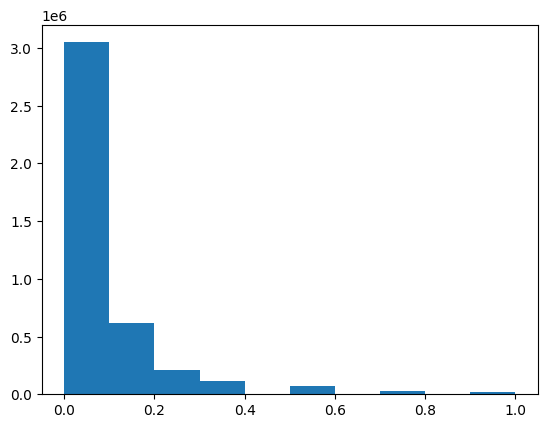

In [163]:
plt.hist(vals)

(array([9.8341e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.0300e+02, 1.1080e+03, 4.8000e+01]),
 array([0.        , 0.09997559, 0.19995117, 0.30004883, 0.39990234,
        0.5       , 0.60009766, 0.70019531, 0.79980469, 0.89990234,
        1.        ]),
 <BarContainer object of 10 artists>)

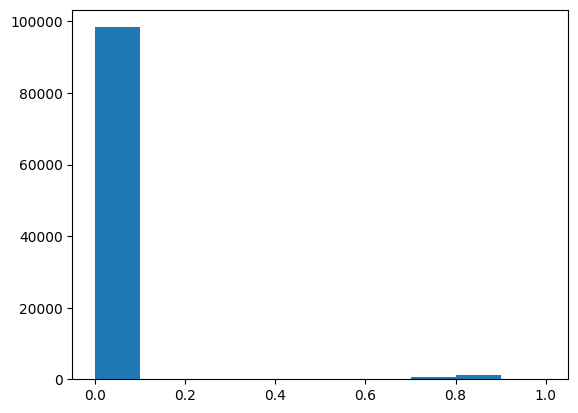

In [164]:
plt.hist(transformed_matrix_power)

In [210]:
np.percentile(points, 99)

0.014495849609375